<a href="https://colab.research.google.com/github/debugk/NER_Covid19/blob/AddEval/NER_BERT_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload model and tokenizer

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import datetime as datetime

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#install the amazing transformers package by huggingface
!pip install transformers

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AdamW

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 778kB 4.5MB/s 
     |████████████████████████████████| 3.0MB 13.2MB/s 
     |████████████████████████████████| 890kB 31.0MB/s 
     |████████████████████████████████| 1.1MB 57.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=35a2ad9d893650253814e1992c878499ac9ae8023cbaf298e6e6ac2dfda8df49
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Using TensorFlow backend.


In [3]:
## setup GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
output_dir = '/content/gdrive/My Drive/Covid19_data/model_save/'
# Load a trained model and vocabulary that you have fine-tuned
model = BertForTokenClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

# Apply the model to a new sentence

In [5]:
test_sentence="""
Safety and efficacy of intravenous bimagrumab in inclusion body myositis (RESILIENT): a randomised, double-blind, placebo-controlled phase 2b trial\tBimagrumab showed a good safety profile, relative to placebo, in individuals with inclusion body myositis but did not improve 6MWD. The strengths of our study are that, to the best of our knowledge, it is the largest randomised controlled trial done in people with inclusion body myositis, and it provides important natural history data over 12 months.
"""

In [7]:
# first tokenize the text
tokenized_sentence = tokenizer.encode( test_sentence, clean_text=False)
test_input_ids = torch.tensor([tokenized_sentence]).cuda()

test_input_ids

Keyword arguments {'clean_text': False} not recognized.


tensor([[  101,  3808,  1998, 21150,  1997, 26721,  8159,  3560, 12170,  2863,
         16523, 12248,  2497,  1999, 10502,  2303,  2026, 20049,  7315,  1006,
         24501, 18622,  4765,  1007,  1024,  1037,  6721,  5084,  1010,  3313,
          1011,  6397,  1010,  2173,  5092,  1011,  4758,  4403,  1016,  2497,
          3979, 12170,  2863, 16523, 12248,  2497,  3662,  1037,  2204,  3808,
          6337,  1010,  5816,  2000,  2173,  5092,  1010,  1999,  3633,  2007,
         10502,  2303,  2026, 20049,  7315,  2021,  2106,  2025,  5335,  1020,
          2213, 21724,  1012,  1996, 20828,  1997,  2256,  2817,  2024,  2008,
          1010,  2000,  1996,  2190,  1997,  2256,  3716,  1010,  2009,  2003,
          1996,  2922,  6721,  5084,  4758,  3979,  2589,  1999,  2111,  2007,
         10502,  2303,  2026, 20049,  7315,  1010,  1998,  2009,  3640,  2590,
          3019,  2381,  2951,  2058,  2260,  2706,  1012,   102]],
       device='cuda:0')

In [8]:
tokenizer.encode(" ")


[101, 102]

In [9]:
model.eval()
# run the sentence through the model
with torch.no_grad():
    output = model(test_input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [10]:
tag_values = ['B-Organization', 'I-Organization', 'B-ChemicalCompound', 'B-Drug', 'B-Disease', 'I-Drug', 'I-Gene', 'B-Virus', 'I-Phenotype', 'B-Gene', 'I-Virus', 'B-Phenotype', 'I-ChemicalCompound', 'B-Chemical', 'I-Disease', 'I-Chemical', 'O', 'PAD']

In [11]:
#tag_values = ['B-Virus', 'B-Organization', 'I-Drug', 'B-Drug', 'O', 'I-Virus', 'B-Chemical', 'B-Disease', 'I-Disease', 'B-Gene', 'I-Organization', 'I-Chemical', 'I-ChemicalCompound', 'I-Gene', 'B-Phenotype', 'I-Phenotype', 'B-ChemicalCompound', 'PAD']
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

entities": [{"entity": "SARS-CoV", "type": "Virus", "start": 48, "end": 56}, {"entity": "SARS-CoV", "type": "Virus", "start": 445, "end": 453}, {"entity": "SARS-CoV", "type": "Virus", "start": 579, "end": 587}, {"entity": "SARS-CoV", "type": "Virus", "start": 675, "end": 683}, {"entity": "SARS-CoV", "type": "Virus", "start": 867, "end": 875}, {"entity": "SARS-CoV", "type": "Virus", "start": 986, "end": 994}, {"entity": "SARS-CoV", "type": "Virus", "start": 1325, "end": 1333}, {"entity": "angiotensin-converting enzyme 2", "type": "Gene", "start": 379, "end": 410}, {"entity": "ACE2", "type": "Gene", "start": 412, "end": 416}, {"entity": "ACE2", "type": "Gene", "start": 751, "end": 755}, {"entity": "host protein", "type": "Gene", "start": 423, "end": 435}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 61, "end": 71}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 458, "end": 468}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 592, "end": 602}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 688, "end": 698}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 879, "end": 889}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 998, "end": 1008}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 1338, "end": 1348}, {"entity": "ACE2 gene", "type": "Gene", "start": 487, "end": 496}, {"entity": "coronaviruses", "type": "Virus", "start": 1219, "end": 1232}, {"entity": "host proteins", "type": "Gene", "start": 1298, "end": 1311}]}

In [12]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	safety
O	and
O	efficacy
O	of
O	intravenous
B-Gene	bimagrumab
O	in
B-Disease	inclusion
I-Disease	body
I-Disease	myositis
O	(
O	resilient
O	)
O	:
O	a
O	randomised
O	,
O	double
O	-
O	blind
O	,
O	placebo
O	-
O	controlled
O	phase
O	2b
O	trial
B-Gene	bimagrumab
O	showed
O	a
O	good
O	safety
O	profile
O	,
O	relative
O	to
O	placebo
O	,
O	in
O	individuals
O	with
B-Disease	inclusion
I-Disease	body
I-Disease	myositis
O	but
O	did
O	not
O	improve
O	6mwd
O	.
O	the
O	strengths
O	of
O	our
O	study
O	are
O	that
O	,
O	to
O	the
O	best
O	of
O	our
O	knowledge
O	,
O	it
O	is
O	the
O	largest
O	randomised
O	controlled
O	trial
O	done
O	in
O	people
O	with
B-Disease	inclusion
I-Disease	body
I-Disease	myositis
O	,
O	and
O	it
O	provides
O	important
O	natural
O	history
O	data
O	over
O	12
O	months
O	.
O	[SEP]


In [43]:
def label_to_dict(labels, tokens, sentence):
    """
      labels:  python array, labels of one sentence
      tokens:  python array
      outdicts: a array of python dictionary
      convert the given labels to outdicts
    """
    outdicts = []

    start_point = 0
    end_point   = 0
    pred_type   = None

    # ignore the uppercase and lowercase
    sentence_upper = sentence.upper()

    for label, token in zip(labels, tokens):
        token = token.upper()

        if label.count('I-'):
            if  label.replace('I-', '') != pred_type:
                print("Unmatched B-type and I-type")
                raise  

            end_point = sentence_upper.find(token, end_point) + len(token)
        
        else:
            if end_point > start_point and pred_type:
                entity = sentence[start_point:end_point]

                outdicts += [{"entity": entity, "type": pred_type, "start": start_point, "end": end_point}]

                # initial again 
                start_point = end_point
                pred_type   = None

            elif label.count('B-'):
                pred_type   = label.replace('B-', '')
                start_point = sentence_upper.find(token, end_point)
                end_point   = start_point + len(token)  

    return outdicts


In [44]:
label_to_dict(new_labels, new_tokens, test_sentence)

[{'end': 46, 'entity': 'bimagrumab', 'start': 36, 'type': 'Gene'},
 {'end': 73,
  'entity': 'inclusion body myositis',
  'start': 50,
  'type': 'Disease'},
 {'end': 159, 'entity': 'Bimagrumab', 'start': 149, 'type': 'Gene'},
 {'end': 254,
  'entity': 'inclusion body myositis',
  'start': 231,
  'type': 'Disease'},
 {'end': 437,
  'entity': 'inclusion body myositis',
  'start': 414,
  'type': 'Disease'}]

In [45]:
test_json = {"text": "Safety and efficacy of intravenous bimagrumab in inclusion body myositis (RESILIENT): a randomised, double-blind, placebo-controlled phase 2b trial\tBimagrumab showed a good safety profile, relative to placebo, in individuals with inclusion body myositis but did not improve 6MWD. The strengths of our study are that, to the best of our knowledge, it is the largest randomised controlled trial done in people with inclusion body myositis, and it provides important natural history data over 12 months.", "entities": [{"entity": "bimagrumab", "type": "Drug", "start": 35, "end": 45}, {"entity": "inclusion body myositis", "type": "Disease", "start": 49, "end": 72}, {"entity": "inclusion body myositis", "type": "Disease", "start": 230, "end": 253}, {"entity": "inclusion body myositis", "type": "Disease", "start": 413, "end": 436}, {"entity": "Bimagrumab", "type": "Drug", "start": 148, "end": 158}, {"entity": "6MWD", "type": "Gene", "start": 274, "end": 278}, {"entity": "pyrimidine nucleoside derivatives", "type": "ChemicalCompound", "start": 273, "end": 306}]}

json_str = json.dumps(test_json)

In [50]:
print(json_str)
with open('tem.json', 'w') as f:
    json.dump(test_json, f, indent = 4)
    json.dump({"text": test_sentence, "entities": label_to_dict(new_labels, new_tokens, test_sentence)}, f, indent = 4)

{"text": "Safety and efficacy of intravenous bimagrumab in inclusion body myositis (RESILIENT): a randomised, double-blind, placebo-controlled phase 2b trial\tBimagrumab showed a good safety profile, relative to placebo, in individuals with inclusion body myositis but did not improve 6MWD. The strengths of our study are that, to the best of our knowledge, it is the largest randomised controlled trial done in people with inclusion body myositis, and it provides important natural history data over 12 months.", "entities": [{"entity": "bimagrumab", "type": "Drug", "start": 35, "end": 45}, {"entity": "inclusion body myositis", "type": "Disease", "start": 49, "end": 72}, {"entity": "inclusion body myositis", "type": "Disease", "start": 230, "end": 253}, {"entity": "inclusion body myositis", "type": "Disease", "start": 413, "end": 436}, {"entity": "Bimagrumab", "type": "Drug", "start": 148, "end": 158}, {"entity": "6MWD", "type": "Gene", "start": 274, "end": 278}, {"entity": "pyrimidine nucl

In [51]:
!ls

gdrive	sample_data  tem.json


In [63]:
#with open('tem.json', 'r') as f:
#    tem = json.load(f)
#    print(tem)

JSONDecodeError: ignored

# Evaluate datasets from biendata

In [76]:
import json

input_dir = '/content/gdrive/My Drive/Covid19_data/'
f_val = open(input_dir+'new_val.json','r')
sentences = [] 
data = []
for line in f_val:
  sentence   = json.loads(line)['text']
  sentences += [sentence]

  oneline = sentence.split('.')
  for sent in oneline:
    if len(sent) == 0: continue
    if sent[0]==' ': sent = sent[1:]
    data.append(sent)

data[:5]

['Shared and distinct genetic risk factors for childhood-onset and adult-onset asthma: genome-wide and transcriptome-wide studies\tGenetic risk factors for adult-onset asthma are largely a subset of the genetic risk for childhood-onset asthma but with overall smaller effects, suggesting a greater role for non-genetic risk factors in adult-onset asthma',
 'Combined with gene expression and tissue enrichment patterns, we suggest that the establishment of disease in children is driven more by dysregulated allergy and epithelial barrier function genes, whereas the cause of adult-onset asthma is more lung-centred and environmentally determined, but with immune-mediated mechanisms driving disease progression in both children and adults',
 'Spousal violence and potentially preventable single and recurrent spontaneous fetal loss in an African setting: cross-sectional study\tSpousal violence increases the likelihood of single and repeated fetal loss',
 'A large proportion of risk for recurrent 

In [53]:
eval_text = []
for data0 in data:
  return_texts = tokenizer.encode(data0)
  eval_text.append(return_texts)

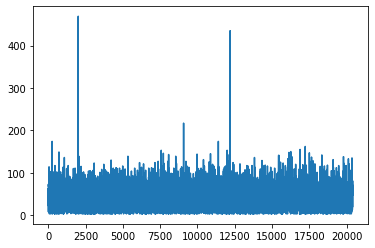

In [54]:
text_len = []
for txt in eval_text:
  text_len.append(len(txt))

plt.plot(text_len)
plt.show()

In [55]:
MAX_LEN = 150
eval_input_ids = pad_sequences(eval_text,
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
eval_input_ids[:2]

array([[  101,  4207,  1998,  5664,  7403,  3891,  5876,  2005,  5593,
         1011, 14447,  1998,  4639,  1011, 14447, 26180,  1024, 13458,
         1011,  2898,  1998, 24051,  8462,  1011,  2898,  2913,  7403,
         3891,  5876,  2005,  4639,  1011, 14447, 26180,  2024,  4321,
         1037, 16745,  1997,  1996,  7403,  3891,  2005,  5593,  1011,
        14447, 26180,  2021,  2007,  3452,  3760,  3896,  1010,  9104,
         1037,  3618,  2535,  2005,  2512,  1011,  7403,  3891,  5876,
         1999,  4639,  1011, 14447, 26180,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [74]:
len(eval_input_ids)

20404

In [56]:
eval_inputs = torch.tensor(eval_input_ids).cuda()
print(len(eval_inputs), len(eval_inputs[0]))

20404 150


In [57]:
bs = 32
eval_data = TensorDataset(eval_inputs)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=bs)

In [58]:
# Put the model into evaluation mode
model.eval()
total_labels , total_tokens = [], []
for batch in eval_dataloader:
    b_input_ids = batch[0]
    #print(b_input_ids)

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        output = model(b_input_ids)
    # Move logits and labels to CPU
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    # join bpe split tokens
    tokens = tokenizer.convert_ids_to_tokens(b_input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    total_labels += [new_labels]
    total_tokens += [new_tokens]

In [59]:
len(total_labels)

638

In [60]:
len(total_tokens)

638

In [66]:
len(sentences)

4839

In [72]:
sentences[637]

"Efficiency and safety of varying the frequency of whole blood donation (INTERVAL): a randomised trial of 45\u2008000 donors\tOver 2 years, more frequent donation than is standard practice in the UK collected substantially more blood without having a major effect on donors' quality of life, physical activity, or cognitive function, but resulted in more donation-related symptoms, deferrals, and iron deficiency."

In [73]:
total_tokens[637]

['[CLS]',
 'challenges',
 'included',
 ':',
 'difficulty',
 'in',
 'generalisation',
 'because',
 'of',
 'scarce',
 'and',
 'context',
 '-',
 'specific',
 'health',
 '-',
 'systems',
 'knowledge',
 ';',
 'no',
 'consensus',
 'for',
 'optimum',
 'service',
 '-',
 'delivery',
 'approaches',
 ',',
 'leading',
 'to',
 'wide',
 'cost',
 'differences',
 ';',
 'no',
 'consensus',
 'for',
 'health',
 'benefits',
 ';',
 'difficulty',
 'in',
 'quantification',
 'of',
 'likely',
 'efficiency',
 'gains',
 ';',
 'and',
 'challenges',
 'in',
 'quantification',
 'of',
 'the',
 'financing',
 'gap',
 'owing',
 'to',
 'uncertainties',
 'about',
 'financial',
 'commitments',
 'for',
 'health',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD

In [ ]:
with open(input_dir+'output_new_val_0715.txt', 'w') as f:
  for token, label in zip(total_tokens, total_labels):
    print(token, label, file=f, sep='\t')